In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
try:
    from sklearn.utils.testing import ignore_warnings
except ModuleNotFoundError:
    from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [3]:
### LOAD THE DATA
data = pd.read_csv('spambase/spambase.csv')
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
### DATA CLEANING
# check for NaN/None/string cells (if any exist throw an error)
for index, row in data.iterrows():
    for val in row.values:
        # check if value is NaN or None
        if pd.isnull(val):
            raise Exception('NaN/None value')
        # check if value is not number
        try:
            float(val)
        except:
            raise Exception('Non number value')

In [5]:
### SPLIT DATA INTO TRAINING/TESTING DATA
# first, extract x/y values from dataframe
X = []
for (col_name, col_data) in data.iteritems():
    if col_name != 'spam':
        X.append(col_data)
X = np.array(X).T
Y = np.array(data['spam'])

# split raw data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.7)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# do the same for scaled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_train, X_scaled_test, Y_scaled_train, Y_scaled_test = train_test_split(X, Y, train_size=.7)
print(X_scaled_train.shape)
print(Y_scaled_train.shape)
print(X_scaled_test.shape)
print(Y_scaled_test.shape)

(3220, 57)
(3220,)
(1381, 57)
(1381,)
(3220, 57)
(3220,)
(1381, 57)
(1381,)


In [26]:
### FIND IMPORTANT COLUMNS
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
feature_imp = pd.Series(clf.feature_importances_,index=[col for col in data.columns if col != 'spam']).sort_values(ascending=False)

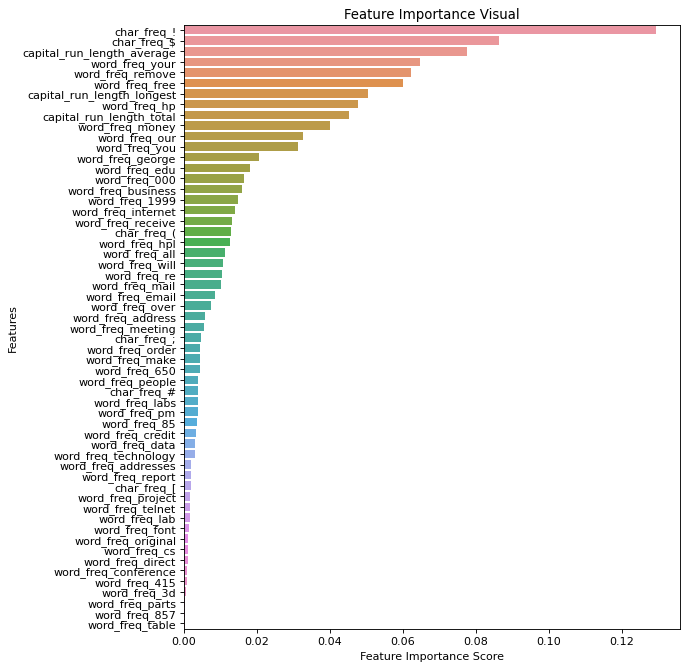

In [27]:
# visualize importances with bargraph
plt.figure(figsize=(8,10), dpi=80)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Visual')
plt.show()

From the graph above, we estimate that anything with an importance score >= 0.1 is POGGERS in our classification task.

In [10]:
# helper function for getting validation curve info, use ignore_warnings to suppress warnings about
# convergence errors, since we end up passing some values that will not converge.
@ignore_warnings(category=ConvergenceWarning)
def test_params(clf, x, y, param, rng):
    return validation_curve(clf, x, y, param_name=param, param_range=rng)

<h3>Logistic Regression</h3>

We must use the scaled data here, otherwise we get max_iter related errors and the model will never converge

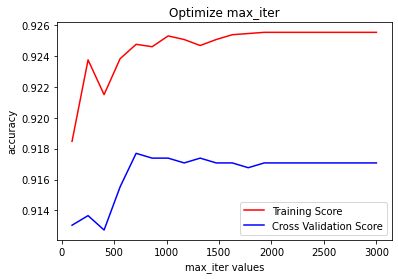

Maximal Cross Validation Score: 0.9177018633540373
Maximal max_iter Value: 710.5263157894736


In [11]:
# find optimal max_iter parameter using validation curve
param_range = np.linspace(100, 3000, 20)

train_scores, valid_scores = test_params(LogisticRegression(), X_scaled_train, Y_scaled_train, 
                                         'max_iter', param_range)

train_score_means = np.mean(train_scores, axis=1)
valid_score_means = np.mean(valid_scores, axis=1)

plt.title('Optimize max_iter')
plt.xlabel('max_iter values')
plt.ylabel('accuracy')
plt.plot(param_range, train_score_means, color='red', label='Training Score')
plt.plot(param_range, valid_score_means, color='blue', label='Cross Validation Score')

plt.legend()
plt.show()

curr_max = float('-inf')
max_val = -1
for i in range(len(param_range)):
    if valid_score_means[i] > curr_max:
        curr_max = valid_score_means[i]
        max_val = param_range[i]
print('Maximal Cross Validation Score:', curr_max)
print('Maximal max_iter Value:', max_val)

As we can see from this graph, the Training Score and Cross Validation Score become stable at around 2000, so we will use that value to keep from needing too many pointless iterations. This will keep the speed of training as fast as possible while still reaching an optimal solution.

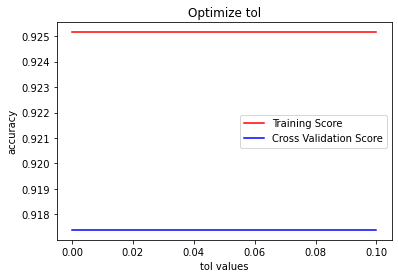

Maximal Cross Validation Score: 0.9173913043478261
Maximal tol Value: 1e-05


In [12]:
# find optimal tol parameter using validation curve
param_range = np.linspace(.00001, .1, 10)

train_scores, valid_scores = test_params(LogisticRegression(max_iter=1350), X_scaled_train, Y_scaled_train, 
                                         'tol', param_range)

train_score_means = np.mean(train_scores, axis=1)
valid_score_means = np.mean(valid_scores, axis=1)

plt.title('Optimize tol')
plt.xlabel('tol values')
plt.ylabel('accuracy')
plt.plot(param_range, train_score_means, color='red', label='Training Score')
plt.plot(param_range, valid_score_means, color='blue', label='Cross Validation Score')

plt.legend()
plt.show()

curr_max = float('-inf')
max_val = -1
for i in range(len(param_range)):
    if valid_score_means[i] > curr_max:
        curr_max = valid_score_means[i]
        max_val = param_range[i]
print('Maximal Cross Validation Score:', curr_max)
print('Maximal tol Value:', max_val)

There does not appear to be any changes in the training based on this variable, which means that it is always going to max_iter iterations. Thus, we will use the value 0.01.

In [21]:
# initialize the model using max_iter=1350 and tol=.01, fit the model, get results.
log_reg = LogisticRegression(max_iter=2000, tol=.01)
log_reg.fit(X_scaled_train, Y_scaled_train)
log_reg_predictions = log_reg.predict(X_scaled_test)
print(classification_report(Y_scaled_test, log_reg_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9280    0.9347    0.9313       827
           1     0.9015    0.8917    0.8966       554

    accuracy                         0.9175      1381
   macro avg     0.9147    0.9132    0.9139      1381
weighted avg     0.9173    0.9175    0.9174      1381



The f1-score of the optimal logistic regression model is 0.9174.

<h3>K Nearest Neighbors</h3>

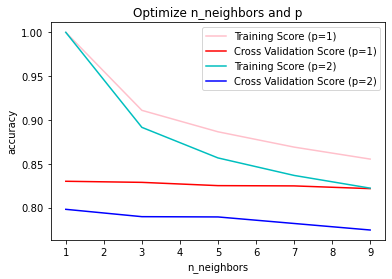

In [32]:
# find optimal n_neighbors and p parameters
neighbors_range = [1, 3, 5, 7, 9]
p_range = [1, 2]
plt.title('Optimize n_neighbors and p')
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
train_scores, valid_scores = test_params(KNeighborsClassifier(p=p_range[0]), X_train, Y_train, 
                                         'n_neighbors', neighbors_range)

train_score_means = np.mean(train_scores, axis=1)
valid_score_means = np.mean(valid_scores, axis=1)

plt.plot(neighbors_range, train_score_means, color='#FFC0CB', label='Training Score (p=1)')
plt.plot(neighbors_range, valid_score_means, color='r', label='Cross Validation Score (p=1)')

train_scores, valid_scores = test_params(KNeighborsClassifier(p=p_range[1]), X_train, Y_train, 
                                         'n_neighbors', neighbors_range)

train_score_means = np.mean(train_scores, axis=1)
valid_score_means = np.mean(valid_scores, axis=1)

plt.plot(neighbors_range, train_score_means, color='c', label='Training Score (p=2)')
plt.plot(neighbors_range, valid_score_means, color='b', label='Cross Validation Score (p=2)')

plt.legend()
plt.show()

Based on this visualization, n_neighbors=1 and p=1 are the optimal parameter values

In [35]:
# initialize the model using n_neighbors=1 and p=1, fit the model, get results.
kneighbors = KNeighborsClassifier(n_neighbors=1, p=1)
kneighbors.fit(X_train, Y_train)
kneighbors_predictions = kneighbors.predict(X_test)
print(classification_report(Y_test, kneighbors_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.8747    0.8575    0.8660       863
           1     0.7701    0.7954    0.7825       518

    accuracy                         0.8342      1381
   macro avg     0.8224    0.8264    0.8243      1381
weighted avg     0.8355    0.8342    0.8347      1381



The f1-score for the optimal kneighbors classifier is 0.8347.

<h3>Support Vector Machine</h3>

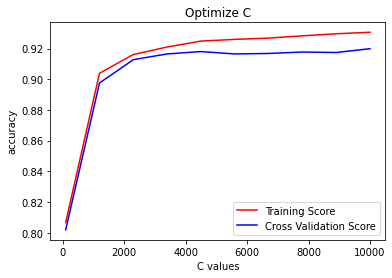

Maximal Cross Validation Score: 0.9198757763975156
Maximal C Value: 10000.0


In [73]:
### SUPPORT VECTOR MACHINE IMPLEMENTATION
# find optimal C parameter using validation curve
param_range = np.linspace(100, 10000, 10)

train_scores, valid_scores = test_params(SVC(kernel='rbf', random_state = 10), X_train, Y_train, 'C', param_range)

train_score_means = np.mean(train_scores, axis=1)
valid_score_means = np.mean(valid_scores, axis=1)

plt.title('Optimize C')
plt.xlabel('C values')
plt.ylabel('accuracy')
plt.plot(param_range, train_score_means, color='red', label='Training Score')
plt.plot(param_range, valid_score_means, color='blue', label='Cross Validation Score')

plt.legend()
plt.show()

curr_max = float('-inf')
max_val = -1
for i in range(len(param_range)):
    if valid_score_means[i] > curr_max:
        curr_max = valid_score_means[i]
        max_val = param_range[i]
print('Maximal Cross Validation Score:', curr_max)
print('Maximal C Value:', max_val)

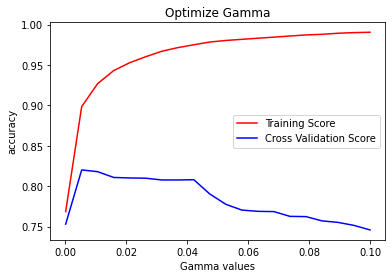

Maximal Cross Validation Score: 0.8201863354037269
Maximal Gamma Value: 0.005357894736842106


In [74]:
# find optimal gamma parameter using validation curve
param_range = np.linspace(.0001, .1, 20)

train_scores, valid_scores = test_params(SVC(kernel='rbf', random_state = 10), X_train, Y_train, 'gamma', param_range)

train_score_means = np.mean(train_scores, axis=1)
valid_score_means = np.mean(valid_scores, axis=1)

plt.title('Optimize Gamma')
plt.xlabel('Gamma values')
plt.ylabel('accuracy')
plt.plot(param_range, train_score_means, color='red', label='Training Score')
plt.plot(param_range, valid_score_means, color='blue', label='Cross Validation Score')

plt.legend()
plt.show()

curr_max = float('-inf')
max_val = -1
for i in range(len(param_range)):
    if valid_score_means[i] > curr_max:
        curr_max = valid_score_means[i]
        max_val = param_range[i]
print('Maximal Cross Validation Score:', curr_max)
print('Maximal Gamma Value:', max_val)

In [78]:
# initialize the model using C = 10000 and Gamma = 0.005357894736842106, fit the model, get results.
supp_vec_mach = SVC(kernel='rbf', random_state = 10, C = 10000, gamma = 0.005357894736842106)
supp_vec_mach.fit(X_train, Y_train)
sup_vec_mach_pred = supp_vec_mach.predict(X_test)
print(classification_report(Y_test, sup_vec_mach_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8850    0.8610    0.8728       813
           1     0.8085    0.8398    0.8238       568

    accuracy                         0.8523      1381
   macro avg     0.8467    0.8504    0.8483      1381
weighted avg     0.8535    0.8523    0.8527      1381



<h3>Random Forest</h3>

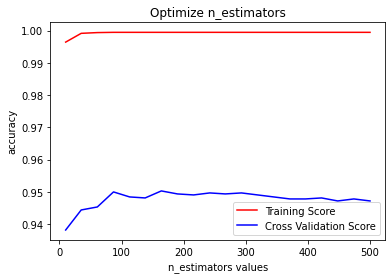

Maximal Cross Validation Score: 0.9503105590062111
Maximal n_estimators Value: 164


In [76]:
### RANDOM FOREST IMPLEMENTATION
# find optimal n_estimators parameter using validation curve
param_range = np.linspace(10, 500, 20, dtype = int)

train_scores, valid_scores = test_params(RandomForestClassifier(max_features="sqrt", random_state = 10), X_train, Y_train, 'n_estimators', param_range)

train_score_means = np.mean(train_scores, axis=1)
valid_score_means = np.mean(valid_scores, axis=1)

plt.title('Optimize n_estimators')
plt.xlabel('n_estimators values')
plt.ylabel('accuracy')
plt.plot(param_range, train_score_means, color='red', label='Training Score')
plt.plot(param_range, valid_score_means, color='blue', label='Cross Validation Score')

plt.legend()
plt.show()

curr_max = float('-inf')
max_val = -1
for i in range(len(param_range)):
    if valid_score_means[i] > curr_max:
        curr_max = valid_score_means[i]
        max_val = param_range[i]
print('Maximal Cross Validation Score:', curr_max)
print('Maximal n_estimators Value:', max_val)


In [77]:
# initialize the model using max_features = "sqrt" and n_estimators = 448, fit the model, get results.
random_forest = RandomForestClassifier(n_estimators = 448, max_features="sqrt", random_state = 10)
random_forest.fit(X_train, Y_train)
random_forest_pred = random_forest.predict(X_test)
print(classification_report(Y_test, random_forest_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9555    0.9779    0.9666       813
           1     0.9672    0.9349    0.9508       568

    accuracy                         0.9602      1381
   macro avg     0.9614    0.9564    0.9587      1381
weighted avg     0.9603    0.9602    0.9601      1381

